In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch.nn as nn
import torch
import itertools

from emnist import get_emnist_data_loaders
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
from training.trainer import Trainer
from hyperparameter import common_hyperparameters, model_specific_hyperparameters
from evaluation.loss import plot_loss
from evaluation.evaluations_utils import create_directory_if_not_exists
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, LambdaLR, CyclicLR

In [9]:
# Generate all possible combinations of hyperparameters
param_combinations = list(itertools.product(*model_specific_hyperparameters.values()))
print(f"Number of Hyperparameter combinations: {len(param_combinations)}")

Number of Hyperparameter combinations: 48


In [10]:
trainers = {}
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Testing parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    num_classes = common_hyperparameters["NUM_CLASSES"]   
    blank_label = common_hyperparameters["BLANK_LABEL"]
    image_height = common_hyperparameters["IMAGE_HEIGHT"]
    digits_per_sequence = common_hyperparameters["DIGITS_PER_SEQUENCE"]
    number_of_sequences = common_hyperparameters["NUMBER_OF_SEQUENCES"]
    epochs = common_hyperparameters["EPOCHS"]
    weight_decay = common_hyperparameters["WEIGHT_DECAY"]

    # Load data
    train_loader, val_loader, test_loader = get_emnist_data_loaders(number_of_sequences, digits_per_sequence, batch_size, batch_size_val)


    # Setup model
    models = {
        # "lstm_cnn": CNN_LSTM(gru_hidden_size=gru_hidden_size, gru_num_layers=gru_num_layers, num_classes=num_classes, cnn_output_height=cnn_output_height),
        "crnn": CRNN(gru_hidden_size, gru_num_layers, num_classes, cnn_output_height)
    }

    criteria = {
        "crnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True),
        "lstm_cnn": nn.CTCLoss(blank=common_hyperparameters['BLANK_LABEL'], reduction='mean', zero_infinity=True)
    }

    optimizer_configs = {
        "adam": torch.optim.Adam,
        # "adam_w": torch.optim.AdamW,
        "adam_w_regulise": torch.optim.AdamW
    }

    scheduler_configs = {
        "step_lr": (StepLR, {"step_size": 5, "gamma": 0.5}),
        "no_scheduler": (None, None),
        # "multi_step_lr": (MultiStepLR, {"milestones": [5, 10, 15], "gamma": 0.5}),
        # "exponential_lr": (ExponentialLR, {"gamma": 0.95}),
        # "cosine_annealing_lr": (CosineAnnealingLR, {"T_max": 10}),
        # "lambda_lr": (LambdaLR, {"lr_lambda": lambda epoch: 0.95 ** epoch}),
        # "cyclic_lr": (CyclicLR, {"base_lr": 0.001, "max_lr": 0.1})
    }

    # Setup trainer
    # lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, test_loader, epochs=epochs, args={
    #         "blank_label": blank_label,
    #         "cnn_output_width": cnn_output_width,
    #     })
    # trainers = {
    #     "lstm_cnn": lstm_trainer
    # }

    for model_name, model in models.items():
        for optimizer_name, optimizer_class in optimizer_configs.items():
            if optimizer_name == "adam_w_regulise":
                optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            else:
                optimizer = optimizer_class(model.parameters(), lr=learning_rate)
            for scheduler_name, (scheduler_class, scheduler_args) in scheduler_configs.items():
                if scheduler_name == "no_scheduler":
                    scheduler = None
                else:
                    scheduler = scheduler_class(optimizer, **scheduler_args)
                criterion = criteria[model_name]

                # Create model name
                abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
                abbreviation = abbreviation.replace(".", "_")
                main_model_name = model_name.split('-', 1)[0]
                trainer_name = f"{model_name}-{optimizer_name}_{scheduler_name}_{abbreviation}_trainer"

                trainer = Trainer(
                    model, model_name, criterion, optimizer, train_loader, val_loader, test_loader,
                    epochs=epochs, args={"blank_label": blank_label, "cnn_output_width": cnn_output_width},
                    scheduler=scheduler
                )
                trainers[trainer_name] = trainer
print(f"Prepared {len(trainers)} models for training.")

Testing parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 1 



Training crnn-adam_no_scheduler_trainer
100%|██████████| 110/110 [00:31<00:00,  3.48it/s]
EPOCH 1/3 - TRAINING. Correct: 0/7000 = 0.0000 - Average CER Score: 0.983
100%|██████████| 2999/2999 [00:13<00:00, 228.39it/s]
EPOCH 1/3 - VALIDATING. Correct: 3/2999 = 0.0010 - Average CER Score: 0.781
100%|██████████| 110/110 [00:31<00:00,  3.50it/s]
EPOCH 2/3 - TRAINING. Correct: 3667/7000 = 0.5239 - Average CER Score: 0.594
100%|██████████| 2999/2999 [00:12<00:00, 237.90it/s]
EPOCH 2/3 - VALIDATING. Correct: 2186/2999 = 0.7289 - Average CER Score: 0.428
100%|██████████| 110/110 [00:31<00:00,  3.47it/s]
EPOCH 3/3 - TRAINING. Correct: 5584/7000 = 0.7977 - Average CER Score: 0.413
100%|██████████| 2999/2999 [00:12<00:00, 237.59it/s]
EPOCH 3/3 - VALIDATING. Correct: 2379/2999 = 0.7933 - Average CER Score: 0.302
100%|██████████| 1/1 [00:00<00:00, 183.17it/s]
TESTING. Correct: 1/1 = 1.0000 - Average CER Score: 0.302


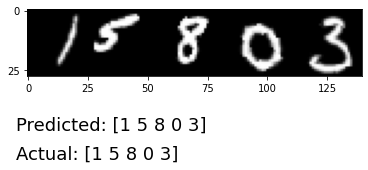

Finished training crnn-adam_no_scheduler_trainer


In [ ]:
metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    metrics = trainer.train_validate_test()
    print(f"Finished training {model_name}")

    # Save the trained model with abbreviation and parameter values
    abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
    abbreviation = abbreviation.replace(".", "_")
    main_model_name = model_name.split('-', 1)[0]
    base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'

    # Add metrics to model name
    metrics_global[f"{model_name}_{abbreviation}"] = metrics
    
    # Save model to disk
    create_directory_if_not_exists(base_path)
    save_path = base_path + "model.pth"
    torch.save(trainer.model.state_dict(), save_path)

In [ ]:
best_model_scores = {}
# Getting the max accuracy and min loss from every model
for model_name, model_scores in metrics_global.items():
    # Min and max for test:
    best_model_scores[model_name] = {}
    best_model_scores[model_name]["max_accuracy_test"] = max(model_scores["test_accuracy"])
    best_model_scores[model_name]["min_loss_test"] = min(model_scores["test_loss"])
    best_model_scores[model_name]["min_cer_test"] = min(model_scores["test_cer"])
    # # Min and max for validation:  
    # best_model_scores[model_name]["max_accuracy_val"] = max(model_scores["val_accuracy"])
    # best_model_scores[model_name]["min_loss_val"] = min(model_scores["val_loss"])
    # best_model_scores[model_name]["min_cer_val"] = min(model_scores["val_cer"])
    # # Min and max for train:
    # best_model_scores[model_name]["max_accuracy_train"] = max(model_scores["train_accuracy"])
    # best_model_scores[model_name]["min_loss_train"] = min(model_scores["train_loss"])
    # best_model_scores[model_name]["min_cer_train"] = min(model_scores["train_cer"])
    print(best_model_scores)

{'crnn-adam_no_scheduler_trainer_G128__L2__H4__W32__LR0_001__BS64__BSV1': {'max_accuracy_test': 1.0, 'min_loss_test': 0.013475929386913776, 'min_cer_test': 0.0}}


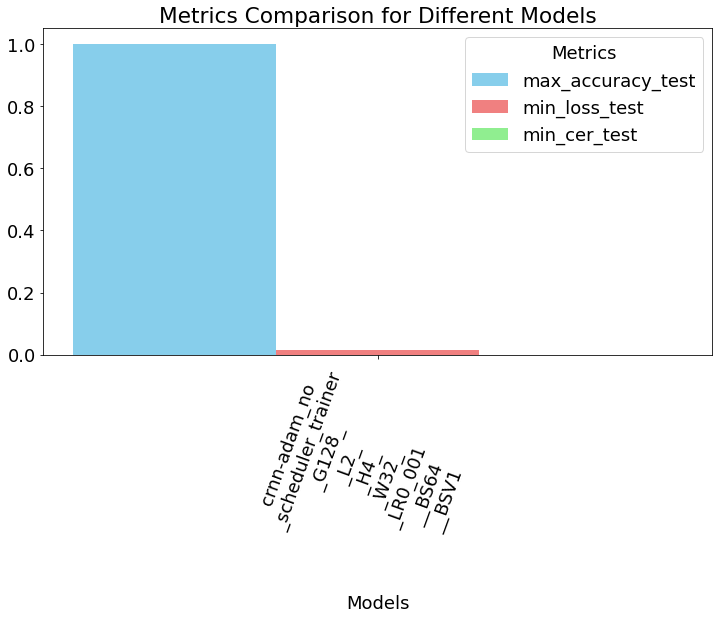

In [ ]:
import numpy as np
from utils import split_and_insert_newline_list 
import matplotlib.pyplot as plt
# Extract metric names and values for each model
model_names = list(best_model_scores.keys())
metric_names = list(best_model_scores[model_names[0]].keys())

# Create a list of colors for each metric
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Set the width of each bar
bar_width = 0.2

# Create a position array for the bars
positions = np.arange(len(model_names))

# Create a grouped bar plot for all metrics
plt.figure(figsize=(12, 6))

for i, metric in enumerate(metric_names):
    metric_scores = [best_model_scores[model][metric] for model in model_names]
    plt.bar(positions + i * bar_width, metric_scores, bar_width, label=metric, color=colors[i])

plt.xlabel('Models')
plt.xticks(positions + (len(metric_names) - 1) * bar_width / 2, split_and_insert_newline_list(model_names), rotation=70)
plt.legend(loc='best', title='Metrics')
plt.title('Metrics Comparison for Different Models')
plt.show()

In [ ]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Plotting loss for parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    for model_name, trainer in trainers.items():
        # Load model
        abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
        abbreviation = abbreviation.replace(".", "_")
        main_model_name = model_name.split('-', 1)[0]
        base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'
        model_path = base_path + "model.pth"
        
        model = model.to("mps")
        model.load_state_dict(torch.load(model_path))

        # Plot the trained model
        plot_loss(model_name=model_name, train_loss_per_epoch=trainer.epoch_train_cers, val_loss_per_epoch=trainer.epoch_val_cers, figure_evaluation_dir=base_path)

Plotting loss for parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 1 

models/lstm_cnn/lstm_cnn-adam_no_scheduler_trainer/lstm_cnn-adam_no_scheduler_trainer_G128__L2__H4__W32__LR0_001__BS64__BSV1/lstm_cnn-adam_no_scheduler_trainer_loss.png


<Figure size 1200x600 with 0 Axes>

Plotting loss for parameters: 
GRU Hidden Size: 128, 
GRU Num Layers: 2, 
CNN Output Height: 4, 
CNN Output Width: 32, 
Learning Rate: 0.001, 
Batch Size: 64, 
Validation Batch Size: 1 

100%|██████████| 1/1 [00:00<00:00, 154.23it/s]
TESTING. Correct: 1/1 = 1.0000 - Average CER Score: 0.266


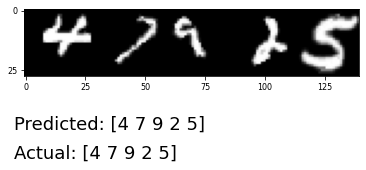

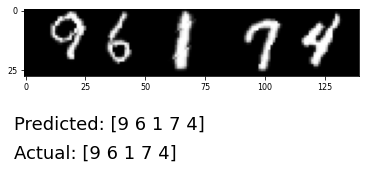

In [ ]:
for param_combination in param_combinations: 
    
    gru_hidden_size = param_combination[0]
    gru_num_layers = param_combination[1]
    cnn_output_height = param_combination[2]
    cnn_output_width = param_combination[3]
    learning_rate = param_combination[4]
    batch_size = param_combination[5]
    batch_size_val = param_combination[6]

    print(f"Plotting loss for parameters: \n"
          f"GRU Hidden Size: {gru_hidden_size}, \n"
          f"GRU Num Layers: {gru_num_layers}, \n"
          f"CNN Output Height: {cnn_output_height}, \n"
          f"CNN Output Width: {cnn_output_width}, \n"
          f"Learning Rate: {learning_rate}, \n"
          f"Batch Size: {batch_size}, \n"
          f"Validation Batch Size: {batch_size_val} \n")

    for model_name, trainer in trainers.items():
        # Load model
        abbreviation = f"G{gru_hidden_size}__L{gru_num_layers}__H{cnn_output_height}__W{cnn_output_width}__LR{learning_rate}__BS{batch_size}__BSV{batch_size_val}"
        abbreviation = abbreviation.replace(".", "_")
        main_model_name = model_name.split('-', 1)[0]
        base_path = f'models/{main_model_name}/{model_name}/{model_name}_{abbreviation}/'
        model_path = base_path + "model.pth"

        # Plot the trained model
        trainer.test(plot_n=2)